# How can we understand what our convolutional neural network (black box) sees and understands when making a decision?



In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from  shutil import copyfile
import random
import zipfile
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow import keras
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# TensorFlow Based Approch to Visualization 



In [2]:
test_path_cats_and_dogs ='../input/dogs-vs-cats/test1.zip'


local_zip = test_path_cats_and_dogs
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./cats-vs-dogs/')
zip_ref.close()

train_path_cats_and_dogs ='../input/dogs-vs-cats/train.zip'


local_zip = train_path_cats_and_dogs
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./cats-vs-dogs/')
zip_ref.close()

BASE_PATH = './cats-vs-dogs/train/'
TRAIN_PATH='./cats-vs-dogs/train_data/'
VAL_PATH='./cats-vs-dogs/validation_data/'

os.mkdir(TRAIN_PATH)
os.mkdir(VAL_PATH)
train_dog=os.path.join(TRAIN_PATH , 'dog')
train_cat=os.path.join(TRAIN_PATH , 'cat')
val_dog=os.path.join(VAL_PATH , 'dog')
val_cat=os.path.join(VAL_PATH , 'cat')
# print(train_cat)
os.mkdir(train_dog)
os.mkdir(train_cat)
os.mkdir(val_dog)
os.mkdir(val_cat)

#segregating cats and dog files for training and validation
cat_file_list=[]
dog_file_list=[]
for file in os.listdir(BASE_PATH):
    if file[:3]=='cat':
        cat_file_list.append(file)
    elif file[:3]=='dog':
        dog_file_list.append(file)
#shuffling the list

train_split=0.8

random.sample(cat_file_list, len(cat_file_list))
random.sample(dog_file_list, len(dog_file_list))
num_of_training_files_cat= int(len(cat_file_list)* train_split)
num_of_training_files_dog= int(len(dog_file_list)* train_split)
print("Total training cat files", num_of_training_files_cat)
print("Training files dog", num_of_training_files_dog)
print("Total filess", len(cat_file_list) + len(dog_file_list) )
print("Total val Dog files", len(dog_file_list) - num_of_training_files_dog)

for file in cat_file_list[:num_of_training_files_cat]:
   copyfile(os.path.join(BASE_PATH, file), os.path.join(train_cat, file))
   
for file in cat_file_list[num_of_training_files_cat:]:
   copyfile(os.path.join(BASE_PATH, file), os.path.join(val_cat, file))

for file in dog_file_list[:num_of_training_files_dog]:
   copyfile(os.path.join(BASE_PATH, file), os.path.join(train_dog, file))
   
for file in dog_file_list[num_of_training_files_dog:]:
   copyfile(os.path.join(BASE_PATH, file), os.path.join(val_dog, file))
    
print("Total val Dog files", len(dog_file_list) - num_of_training_files_dog)

batch_size = 128 #128
epochs = 20
IMG_HEIGHT = 150
IMG_WIDTH = 150


train_image_generator = ImageDataGenerator(
                                                rescale=1./255,
                                                rotation_range=45,
                                                width_shift_range=.15,
                                                height_shift_range=.15,
                                                horizontal_flip=True,
                                                zoom_range=0.3                         

                                            ) # Generator for our training data


validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=TRAIN_PATH,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=VAL_PATH,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')


# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Total training cat files 10000
Training files dog 10000
Total filess 25000
Total val Dog files 2500
Total val Dog files 2500
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


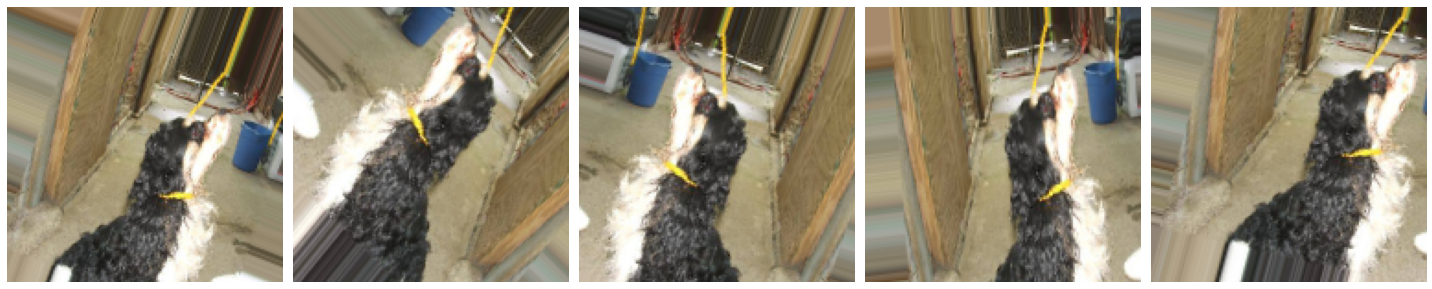

In [3]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

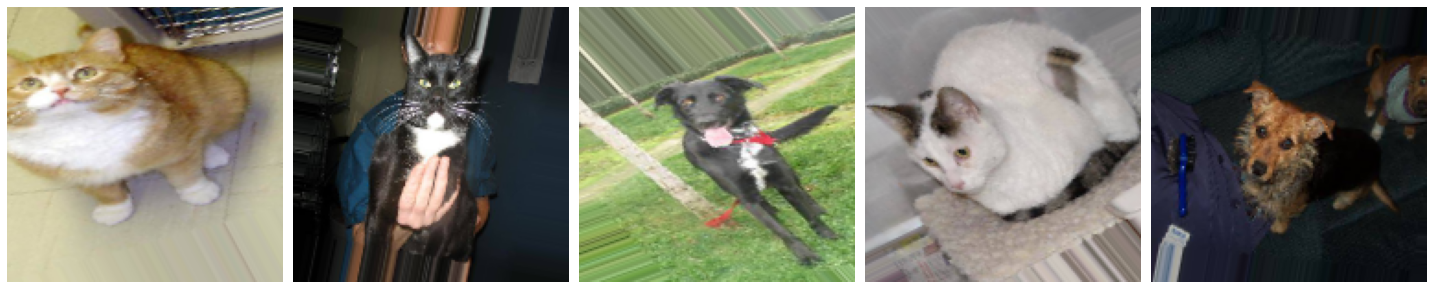

In [4]:
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

In [5]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


batch_size=100
history = model.fit(
    train_data_gen,
    epochs=10,
    validation_data=val_data_gen,
)

2022-08-13 13:56:47.118938: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0

2022-08-13 13:56:48.575750: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
157/157 [==============================] - 283s 2s/step - loss: 0.7561 - accuracy: 0.5042 - val_loss: 0.6680 - val_accuracy: 0.5218
Epoch 2/10
157/157 [==============================] - 282s 2s/step - loss: 0.6533 - accuracy: 0.5743 - val_loss: 0.6236 - val_accuracy: 0.6324
Epoch 3/10
157/157 [==============================] - 283s 2s/step - loss: 0.6164 - accuracy: 0.6276 - val_loss: 0.5597 - val_accuracy: 0.6828
Epoch 4/10
157/157 [==============================] - 283s 2s/step - loss: 0.5769 - accuracy: 0.6686 - val_loss: 0.5429 - val_accuracy: 0.7172
Epoch 5/10
157/157 [==============================] - 283s 2s/step - loss: 0.5588 - accuracy: 0.6852 - val_loss: 0.5154 - val_accuracy: 0.7256
Epoch 6/10
157/157 [==============================] - 280s 2s/step - loss: 0.5410 - accuracy: 0.7028 - val_loss: 0.5547 - val_accuracy: 0.7298
Epoch 7/10
157/157 [==============================] - 280s 2s/step - loss: 0.5316 - accuracy: 0.7121 - val_loss: 0.4976 - val_accuracy: 0.7792

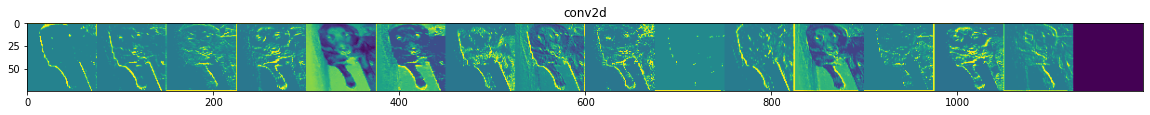

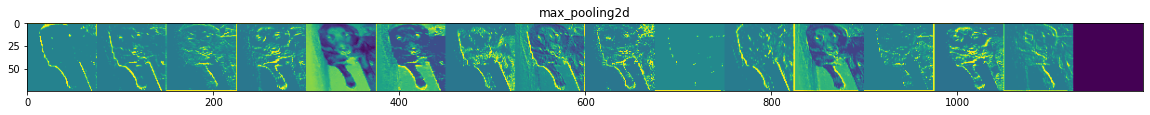

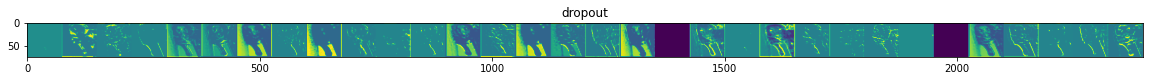

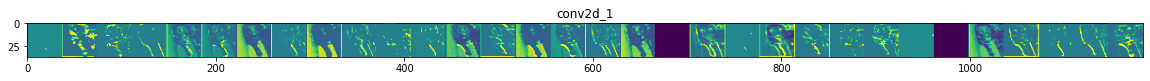

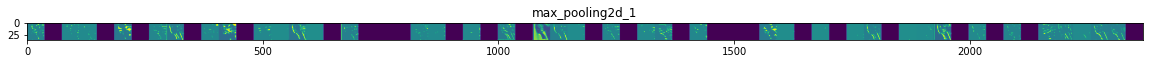

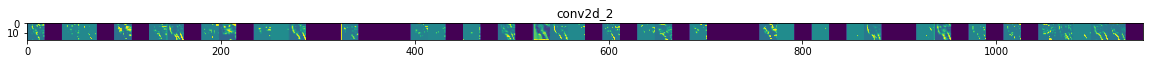

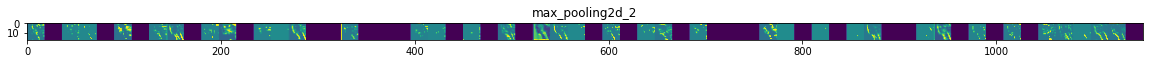

In [6]:
def plotFilters(conv_filter):
    fig, axes = plt.subplots(1, 3, figsize=(5,5))
    axes = axes.flatten()
    for img, ax in zip( conv_filter, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


np.seterr(divide='ignore', invalid='ignore')
img_path='./cats-vs-dogs/train_data/dog/dog.10000.jpg' #dog
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
#cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
#dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

#img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
#   print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

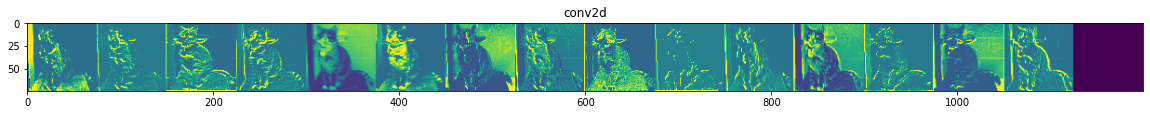

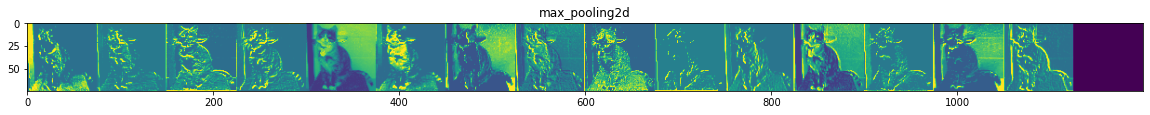

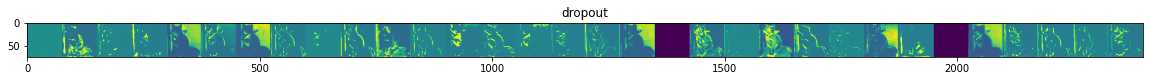

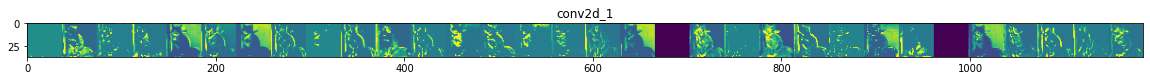

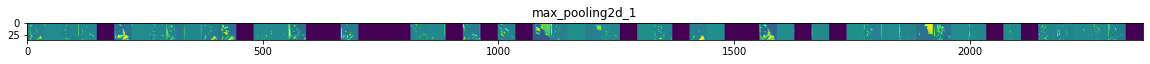

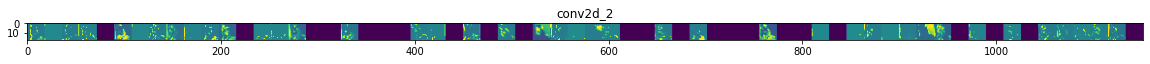

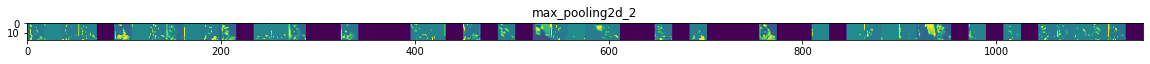

In [7]:
img_path='./cats-vs-dogs/train_data/cat/cat.9999.jpg' #dog
# Define a new Model, Input= image 
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
#Load the input image
img = load_img(img_path, target_size=(150, 150))  
# Convert ht image to Array of dimension (150,150,3)
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)                   
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
#   print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x 

    # Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )
    
model.save('./model1.h5')

# Grab Cam - Gradient-weighted Class Activation Mapping 
## Visual Explanations from Deep Networks

Research Paper : https://arxiv.org/abs/1610.02391 

Papers with code : https://paperswithcode.com/paper/grad-cam-visual-explanations-from-deep


<img src="https://camo.githubusercontent.com/ffae15bf007544c9e651f1744157b8eeb2603e17bb8d5c24ba6411bbc5b236c2/687474703a2f2f692e696d6775722e636f6d2f4a614762645a352e706e67">



The technique is an improvement over previous approaches in versatility and accuracy. It is complex but, luckily, the output is intuitive. From a high-level, we take an image as input and create a model that is cut off at the layer for which we want to create a Grad-CAM heat-map. We attach the fully-connected layers for prediction. We then run the input through the model, grab the layer output, and loss. Next, we find the gradient of the output of our desired model layer w.r.t. the model loss. From there, we take sections of the gradient which contribute to the prediction, reduce, resize, and rescale so that the heat-map can be overlaid with the original image

We started out creating Grad-CAM heat-maps for the last convolutional layer in our model, Conv_1. In theory, the heat-map for this layer should display the most accurate visual explanation of the object being classified by the model.


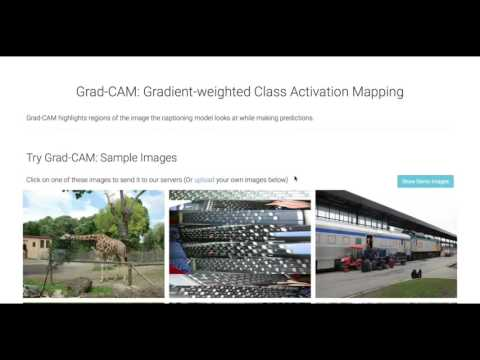

In [8]:
from IPython.display import YouTubeVideo
YouTubeVideo('COjUB9Izk6E', width=800, height=450)

49152/35363 [=========================================] - 0s 0us/step
Predicted: [('n02504458', 'African_elephant', 9.862387)]


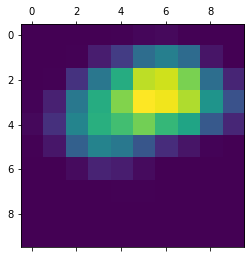

In [9]:
model_builder = tf.keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = tf.keras.applications.xception.preprocess_input
decode_predictions = tf.keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
img_path = tf.keras.utils.get_file(
    "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
)


def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

## Gard-CAM Overview

The basic idea behind Grad-CAM is the same as the basic idea behind CAM: we want to exploit the spatial information that is preserved through convolutional layers, in order to understand which parts of an input image were important for a classification decision.

Similar to CAM, Grad-CAM uses the feature maps produced by the last convolutional layer of a CNN. The authors of Grad-CAM argue, “we can expect the last convolutional layers to have the best compromise between high-level semantics and detailed spatial information.”

Here is a sketch showing the parts of a neural network model relevant to Grad-CAM:


<img src="https://glassboxmedicine.files.wordpress.com/2020/05/grad-cam-sketch.png">

The CNN is composed of some convolutional layers (shown as “conv” in the sketch). The feature maps produced by the final convolutional layer are shown as A1, A2, and A3, the same as in the CAM sketch.

At this point, for CAM we would need to do global average pooling followed by a fully connected layer. For Grad-CAM, we can do anything – for example, multiple fully connected layers – which is shown as “any neural network layers” in the sketch. The only requirement is that the layers we insert after A1, A2, and A3 have to be differentiable so that we can get a gradient. Finally, we have our classification outputs for airplane, dog, cat, person, etc.

The difference between CAM and Grad-CAM is in how the feature maps A1, A2, and A3 are weighted to make the final heatmap. In CAM, we weight these feature maps using weights taken out of the last fully-connected layer of the network. In Grad-CAM, we weight the feature maps using “alpha values” that are calculated based on gradients. Therefore, Grad-CAM does not require a particular architecture, because we can calculate gradients through any kind of neural network layer we want. The “Grad” in Grad-CAM stands for “gradient.”

The output of Grad-CAM is a “class-discriminative localization map”, i.e. a heatmap where the hot part corresponds to a particular class. If there are 10 possible output classes, then for a particular input image, you can make 10 different Grad-CAM heatmaps, one heatmap for each class.

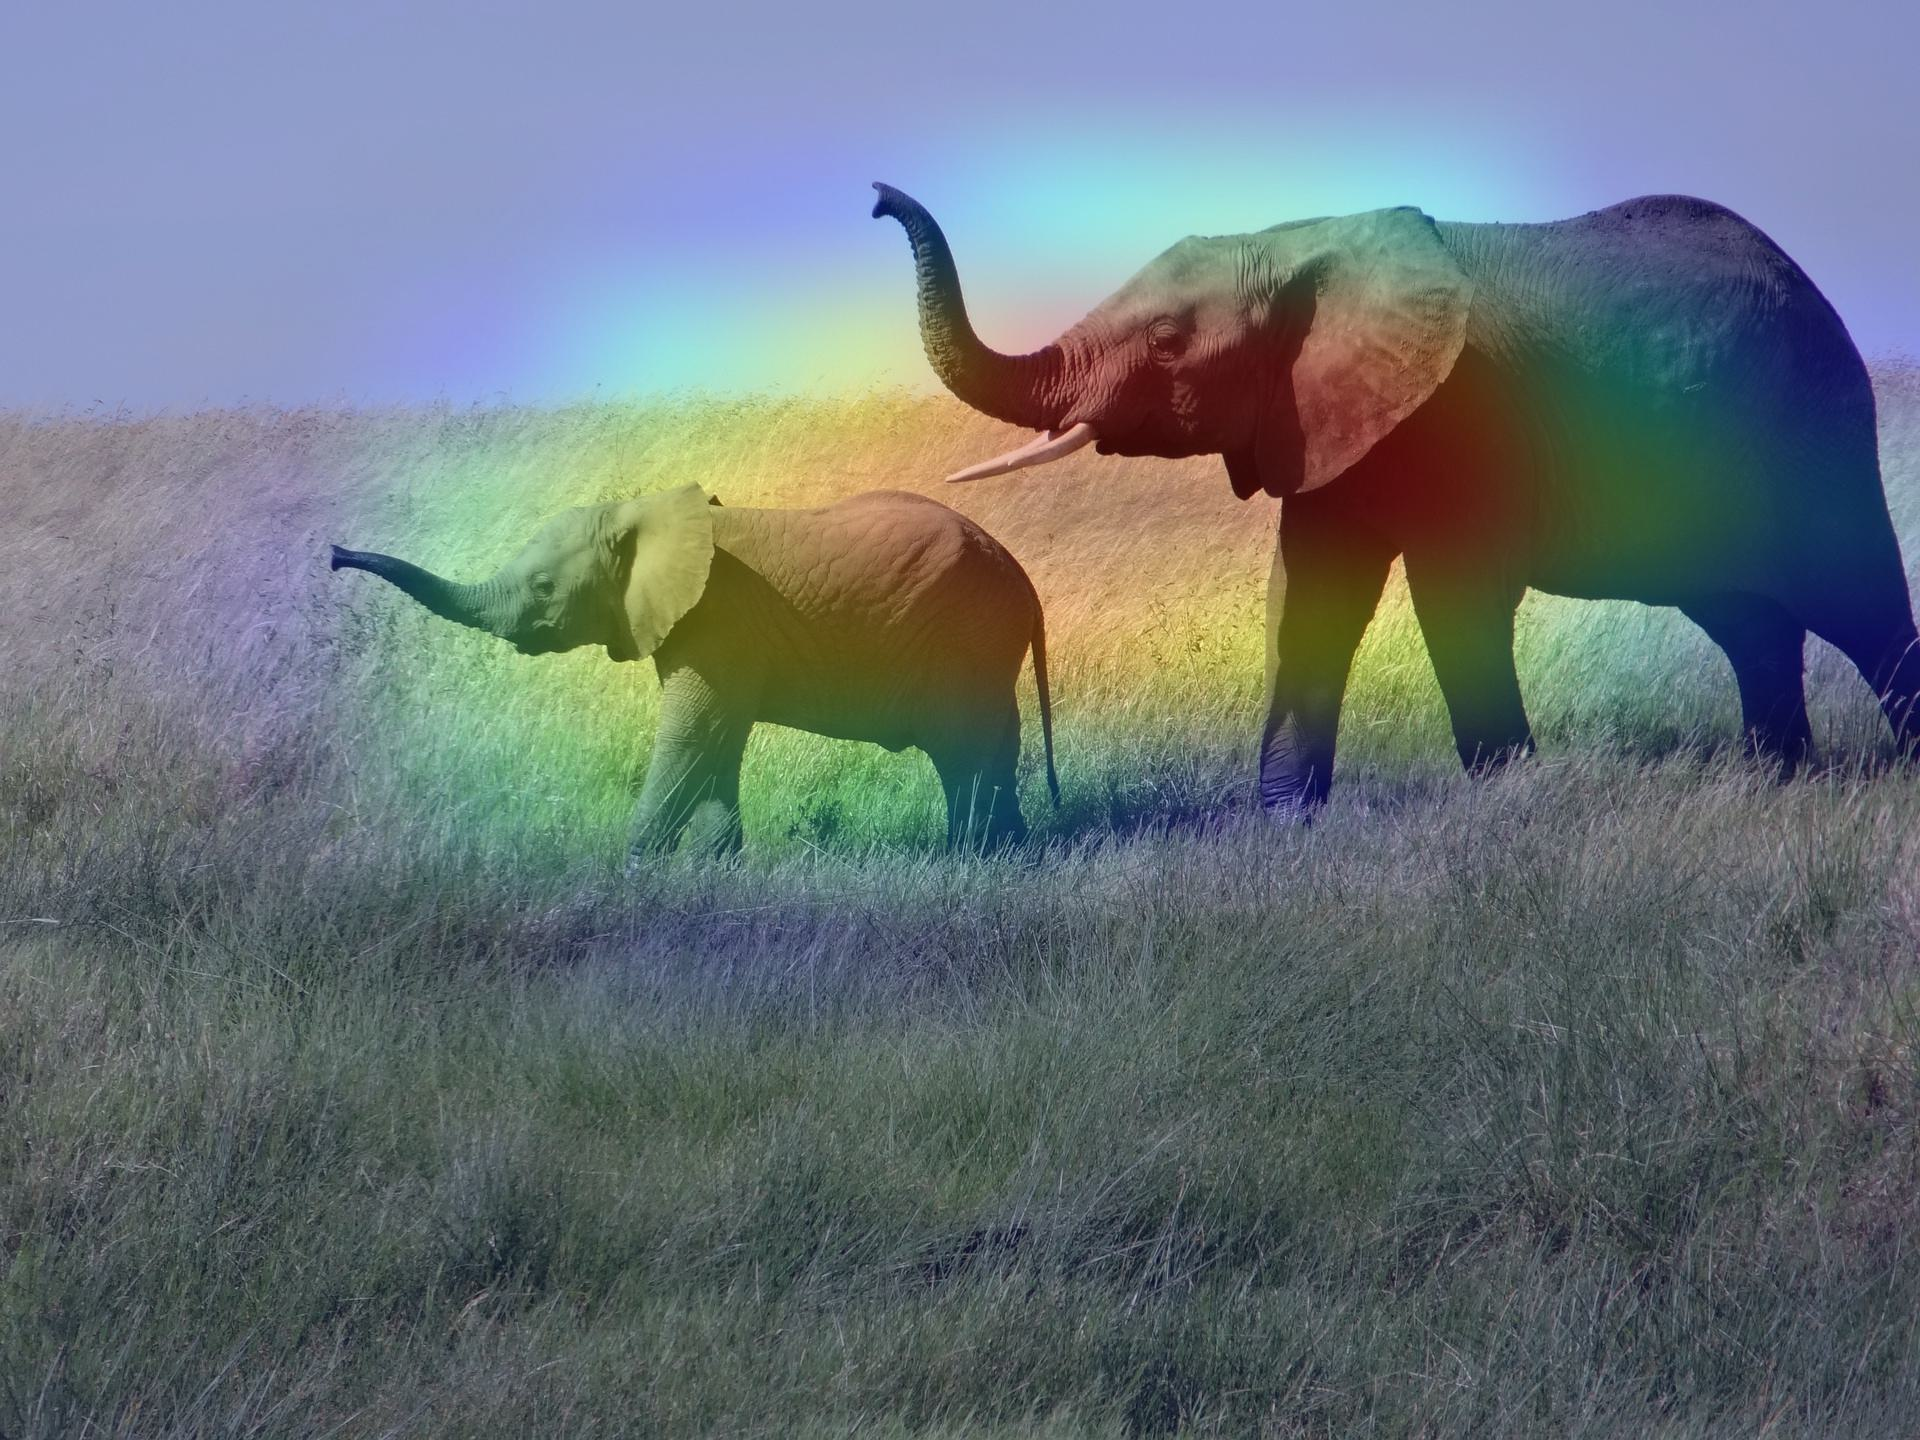

In [10]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

81920/72452 [=================================] - 0s 0us/step


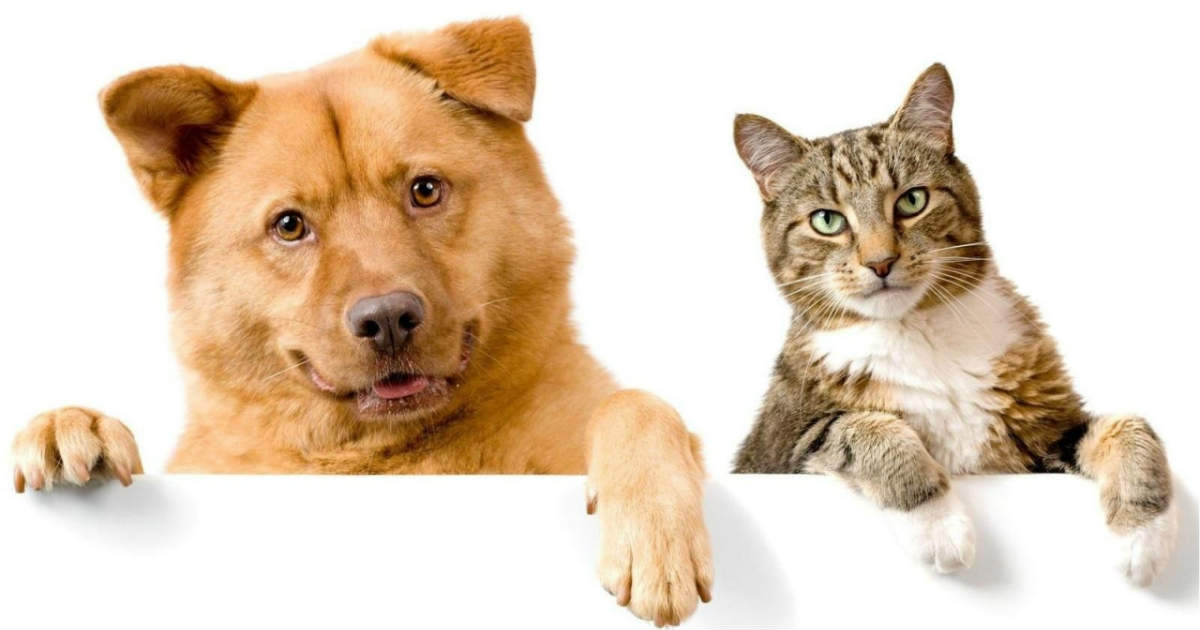

Predicted: [('n02112137', 'chow', 4.611242), ('n02124075', 'Egyptian_cat', 4.3817377)]


In [11]:
img_path = keras.utils.get_file(
    "cat_and_dog.jpg",
    "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg",
)

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=2)[0])

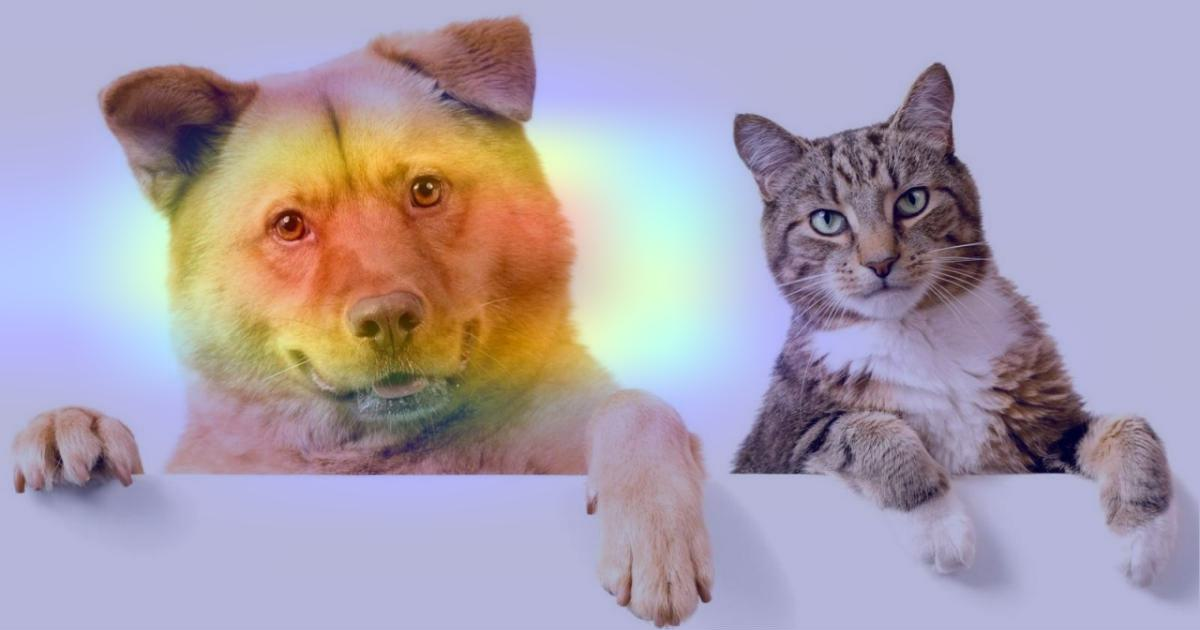

In [12]:
#We generate class activation heatmap for "chow," the class index is 260
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=260)

save_and_display_gradcam(img_path, heatmap)

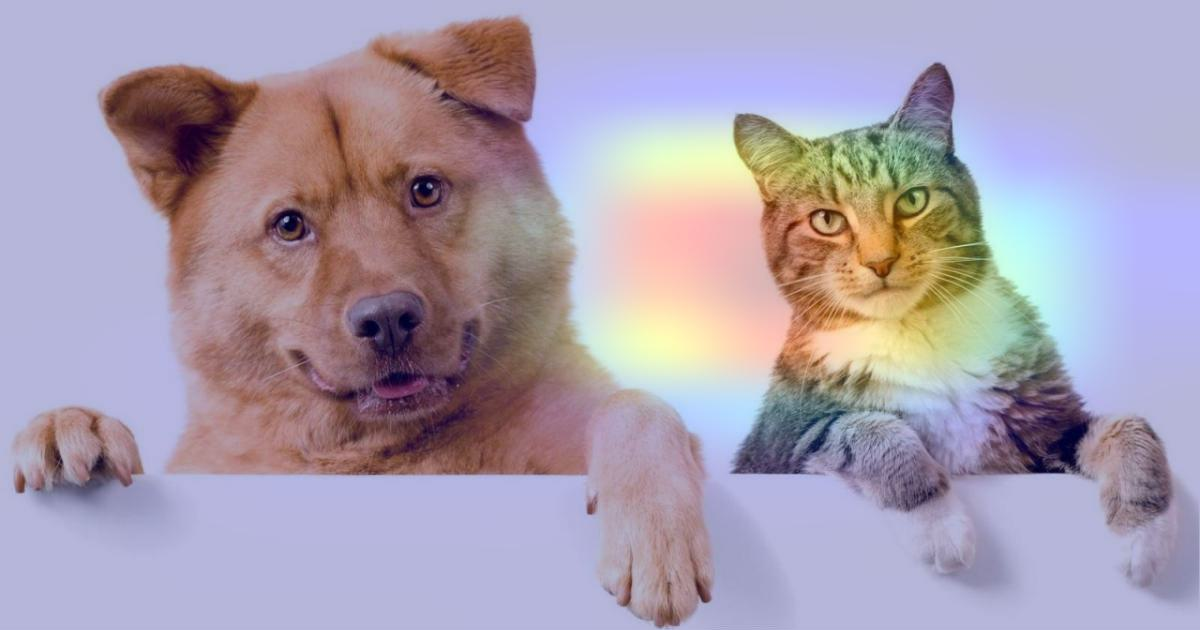

In [13]:
#We generate class activation heatmap for "egyptian cat," the class index is 285
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=285)

save_and_display_gradcam(img_path, heatmap)

Grad-CAM can be used for weakly-supervised localization, i.e. determining the location of particular objects using a model that was trained only on whole-image labels rather than explicit location annotations.

Grad-CAM can also be used for weakly-supervised segmentation, in which the model predicts all of the pixels that belong to particular objects, without requiring pixel-level labels for training:

<img src= "https://glassboxmedicine.files.wordpress.com/2020/05/figure-4-excerpt.png">


we’ve hopefully provided some useful insights into and tools for convolutional neural network visual explanation using the Grad-CAM. With the help of cats & dogs, we’ve explored how a model differentiates classes. We’ve improved the Grad-CAM results from the final convolutional layer by considering heat-maps from all layers of the model.Machine learning is an iterative process where our models are never good enough. We hope that the techniques presented here will help provide more transparency and create more trust in models throughout the improvement process. At Forsight, we use Grad-CAM heat-maps to identify erroneous areas of emphasis by our models.

# TF-Explain : A Tensorflow 2.0 library for deep learning model interpretability.

The library is adapted to the Tensorflow 2.0 workflow, using tf.keras API as possible. It provides:

- Heatmaps Visualizations & Gradients Analysis
- Both off-training and tf.keras.Callback Usages
- Tensorboard Integration

<img src="https://d37oebn0w9ir6a.cloudfront.net/account_16771/3_5c0602cf4b164e4fa33cbdf351fde838.gif">

## Why Interpretability?

The main challenge when working with deep neural networks is **to understand the behavior of trained networks** . It is crucial both to the scientist to debug and improve current model, and to the users **to help them to trust the method**. As a human, it is difficult to get feedback from a neural network. Interpretability has emerged in research to help tackling this:

- Analysis of decisions over a validation set helps identify issues with the network (for instance bias in dataset, mislabeled data)
- Heatmap visualizations are often appreciated by non-initiated users

However, those methods are not well-integrated in deep learning workflow as of today.

### The solution: off the shelf analysis tools for your tf.keras models
tf-explain implements interpretability methods as Tensorflow 2.0 callbacks to ease neural networks’ understanding.

The library was built to offer a comprehensive list of interpretability methods, directly usable in your Tensorflow workflow



## There are two Methods for using tf-explain with can be represeted such as : 
- After the model is trained to check the explanation of model 
- During model trainig in the form of Callbacks in TensorFlow


## After Training the model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 542.3 kB/s eta 0:00:00
553476096/553467096 [==============================] - 4s 0us/step


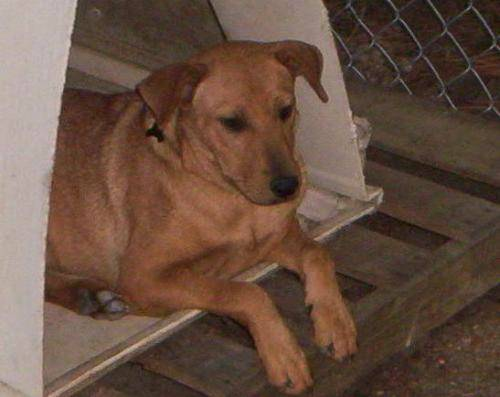

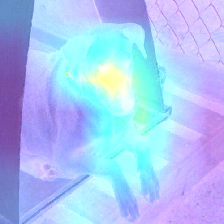

In [14]:
!pip install tf-explain
from tf_explain.core.grad_cam import GradCAM

# Load pretrained model or your own
model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=True)
IMAGE_PATH = "../input/dogs-cats-images/dataset/training_set/dogs/dog.100.jpg"
# Load a sample image (or multiple ones)
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
data = ([img], None)

# Start explainer
explainer = GradCAM()
grid = explainer.explain(data, model, class_index=281)  # 281 is the tabby cat index in ImageNet

explainer.save(grid, ".", "grad_cam.png")
display(Image(IMAGE_PATH))
display(Image("grad_cam.png"))

## While Training the model :

## Available Methods

1. [Activations Visualization](#activations-visualization)
1. [Vanilla Gradients](#vanilla-gradients)
1. [Gradients*Inputs](#gradients-inputs)
1. [Occlusion Sensitivity](#occlusion-sensitivity)
1. [Grad CAM (Class Activation Maps)](#grad-cam)
1. [SmoothGrad](#smoothgrad)
1. [Integrated Gradients](#integrated-gradients)

### Activations Visualization

**Visualize how a given input comes out of a specific activation layer**



```python
from tensorflow import keras
model = keras.models.load_model('./model1.h5')
from tf_explain.callbacks.activations_visualization import ActivationsVisualizationCallback
output_dir = "./outputs/"
# model = [...]

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

img_path='./cats-vs-dogs/train_data/cat/cat.9999.jpg'

img = load_img(img_path, target_size=(150, 150))  
# Convert ht image to Array of dimension (150,150,3)
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)                   
# Rescale by 1/255
x /= 255.0

callbacks = [
    ActivationsVisualizationCallback(
        validation_data=(x,1),
        layers_name=["max_pooling2d_4"],
        output_dir=output_dir,
    ),
]

model.fit(train_data_gen, epochs=1,callbacks=callbacks)
```

**Note**: TensorBoard requires a running kernel, so its output will only be available in an editor session. 

This is a static image of an interactive graphic. For the interactive version, fork your own copy of this kernel and open it in the editor.
<img src="https://www.kaggle.com/static/images/tensorboard-example.png">

### Vanilla Gradients

Visualize gradients importance on input image

```python
from tf_explain.callbacks.vanilla_gradients import VanillaGradientsCallback

model = [...]

callbacks = [
    VanillaGradientsCallback(
        validation_data=(x_val, y_val),
        class_index=0,
        output_dir=output_dir,
    ),
]

model.fit(x_train, y_train, batch_size=2, epochs=2, callbacks=callbacks)

```


### Gradients*Inputs

Variant of [Vanilla Gradients](#vanilla-gradients) ponderating gradients with input values

```python
from tf_explain.callbacks.gradients_inputs import GradientsInputsCallback

model = [...]

callbacks = [
    GradientsInputsCallback(
        validation_data=(x_val, y_val),
        class_index=0,
        output_dir=output_dir,
    ),
]

model.fit(x_train, y_train, batch_size=2, epochs=2, callbacks=callbacks)
```



### Occlusion Sensitivity

Visualize how parts of the image affects neural network's confidence by occluding parts iteratively

```python
from tf_explain.callbacks.occlusion_sensitivity import OcclusionSensitivityCallback

model = [...]

callbacks = [
    OcclusionSensitivityCallback(
        validation_data=(x_val, y_val),
        class_index=0,
        patch_size=4,
        output_dir=output_dir,
    ),
]

model.fit(x_train, y_train, batch_size=2, epochs=2, callbacks=callbacks)
```


### Grad CAM

Visualize how parts of the image affects neural network's output by looking into the activation maps

From [Grad-CAM: Visual Explanations from Deep Networks
via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

```python
from tf_explain.callbacks.grad_cam import GradCAMCallback

model = [...]

callbacks = [
    GradCAMCallback(
        validation_data=(x_val, y_val),
        class_index=0,
        output_dir=output_dir,
    )
]

model.fit(x_train, y_train, batch_size=2, epochs=2, callbacks=callbacks)
```

### SmoothGrad

Visualize stabilized gradients on the inputs towards the decision

From [SmoothGrad: removing noise by adding noise](https://arxiv.org/abs/1706.03825)

```python
from tf_explain.callbacks.smoothgrad import SmoothGradCallback

model = [...]

callbacks = [
    SmoothGradCallback(
        validation_data=(x_val, y_val),
        class_index=0,
        num_samples=20,
        noise=1.,
        output_dir=output_dir,
    )
]

model.fit(x_train, y_train, batch_size=2, epochs=2, callbacks=callbacks)
```


### Integrated Gradients

Visualize an average of the gradients along the construction of the input towards the decision

From [Axiomatic Attribution for Deep Networks](https://arxiv.org/pdf/1703.01365.pdf)

```python
from tf_explain.callbacks.integrated_gradients import IntegratedGradientsCallback

model = [...]

callbacks = [
    IntegratedGradientsCallback(
        validation_data=(x_val, y_val),
        class_index=0,
        n_steps=20,
        output_dir=output_dir,
    )
]

model.fit(x_train, y_train, batch_size=2, epochs=2, callbacks=callbacks)
```

